In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq

In [22]:
q = """
SELECT
  practice,
  quantity_per_item,
  SUM(items) as items

FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc

WHERE
    (bnf_code LIKE "0205051R0%"     ##ramipril
     OR bnf_code LIKE "0212000B0%"  ##atrovastatin
     OR bnf_code LIKE "0212000Y0%"  ##simvastatin
     OR bnf_code LIKE "0602010V0%"  ##levothyroxine
     OR bnf_code LIKE "0206020A0%") ##amlodipine
AND
    (bnf_name LIKE '%_Tab%' 
     OR bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND month >= '2018-08-01'
AND month <= '2019-07-01'

GROUP BY
  practice,
  quantity_per_item
"""
qty_per_item = bq.cached_read(q, csv_path='qty_per_item.csv.zip')
qty_per_item.head()

,practice,quantity_per_item,items
0,N81022,43,1
1,N81022,72,2
2,N81026,45,13
3,N81026,94,14
4,N81062,63,7
...,...,...,...
167134,H81031,252,1
167135,J82138,252,1
167136,P91018,252,2
167137,E84617,252,1


In [3]:
outcome = qty_per_item.loc[(qty_per_item["quantity_per_item"].isin([28,56,84]))]
outcome['quantity_per_item'] = outcome['quantity_per_item'].replace([28,56,84],[1,0,0])
outcome = outcome.groupby(['practice','quantity_per_item']).sum()
outcome = outcome.unstack()
outcome = outcome.reset_index()
outcome['denominator'] = outcome['items'].sum(axis=1)
outcome['rate'] = outcome['items'][1] / outcome['denominator']
outcome

C:\Users\ajwalker\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


practice    items          denominator      rate
quantity_per_item                 0        1                      
0                   A81001   5243.0   5860.0     11103.0  0.527785
1                   A81002  22703.0  38712.0     61415.0  0.630335
2                   A81004  10306.0  16142.0     26448.0  0.610330
3                   A81005   1920.0  31762.0     33682.0  0.942996
4                   A81006   6566.0  46558.0     53124.0  0.876402
...                    ...      ...      ...         ...       ...
8357                Y06487      NaN      2.0         2.0  1.000000
8358                Y06492      1.0      NaN         1.0       NaN
8359                Y06495      NaN      1.0         1.0  1.000000
8360                Y06498      NaN      1.0         1.0  1.000000
8361                Y06504      1.0      NaN         1.0       NaN

[8362 rows x 5 columns]

In [4]:
q = '''
SELECT
  DISTINCT practice,
  pct
FROM
  ebmdatalab.hscic.normalised_prescribing_standard
LEFT JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
ORDER BY
  practice
'''
practices = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')


phe = pd.read_csv('indicators-GP.data.csv.zip')

mask = (phe['Indicator Name'] == 'Deprivation score (IMD 2015)') & (phe['Area Type'] == 'GP')
imd = phe.loc[mask, ['Area Code','Value']]
imd = imd.set_index('Area Code')

mask = (phe['Indicator Name'] == '% who have a positive experience of their GP practice') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2018)
satisfaction = phe.loc[mask, ['Area Code','Value']]
satisfaction = satisfaction.set_index('Area Code')

mask = (phe['Indicator Name'] == '% with a long-standing health condition') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2018)
long_term_health = phe.loc[mask, ['Area Code','Value']]
long_term_health = long_term_health.set_index('Area Code')

mask = (phe['Indicator Name'] == '% aged 65+ years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2018)
over_65 = phe.loc[mask, ['Area Code','Value']]
over_65 = over_65.set_index('Area Code')

mask = (phe['Indicator Name'] == '% aged under 18 years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2018)
under_18 = phe.loc[mask, ['Area Code','Value']]
under_18 = under_18.set_index('Area Code')



qof = pd.read_csv('ACHIEVEMENT_EXCEPTIONS.csv')
qof_map = pd.read_csv('INDICATOR_MAPPINGS.csv')
qof = qof.merge(qof_map[['INDICATOR_CODE','DOMAIN_CODE']], how='inner', on='INDICATOR_CODE', copy=False)
qof_all = qof.loc[qof.MEASURE == 'ACHIEVED_POINTS'].groupby(['PRACTICE_CODE','DOMAIN_CODE']).sum()
qof_all = qof_all.unstack(level=1) #.reset_index(col_level=0)
qof_all.columns = qof_all.columns.droplevel(0)
qof_all['TOTAL'] = qof_all['CL'] + qof_all['PH'] + qof_all['PHAS']

q = '''
SELECT
  code,
  dispensing_patients
FROM
  ebmdatalab.bsa.dispensing_practices_jan2017
ORDER BY
  code ASC
'''
dispensing = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')

q = '''
SELECT
  practice,
  SUM(items) AS total_items
FROM
  ebmdatalab.hscic.normalised_prescribing_standard
WHERE
  month >= TIMESTAMP("2018-01-01")
  AND month <= TIMESTAMP("2018-12-01")
GROUP BY
  practice
'''
prescribing_volume = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')



q = '''
SELECT
  code AS practice, ru.LSOA11NM, SUBSTR(RUC11CD,1,1) AS ruc11cd, RUC11
FROM
  ebmdatalab.ONS.small_area_rural_urban ru
INNER JOIN
  ebmdatalab.ONS.postcode_to_lsoa_map m
ON
  ru.LSOA11CD = m.lsoa11cd
INNER JOIN
  ebmdatalab.hscic.practices
ON
  pcds = postcode
'''
urban_rural = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')


q = '''
SELECT
  practice,
  AVG(total_list_size) as list_size
FROM
  ebmdatalab.hscic.practice_statistics
WHERE
  month >= TIMESTAMP("2018-01-01")
  AND month <= TIMESTAMP("2018-12-01")
GROUP BY
  practice
ORDER BY
  practice
'''
list_size = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')



gps_per_practice = pd.read_csv('gps_per_practice_sept_2017.csv')



measures = {'ktt9_cephalosporins':'Antibiotic stewardship: co-amoxiclav, cephalosporins &amp; quinolones (KTT9)',
            'ktt9_uti_antibiotics':'Antibiotic stewardship: three-day courses for uncomplicated UTIs (KTT9)',
            'ktt9_antibiotics':'Antibiotic stewardship: volume of antibiotic prescribing (KTT9)',
            'ciclosporin':'Ciclosporin and tacrolimus oral preparations prescribed generically',
            'coproxamol':'Co-proxamol',
            'desogestrel':'Desogestrel prescribed as a branded product',
            'diltiazem':'Diltiazem preparations (>60mg) prescribed generically',
            #'doacs':'Direct Oral Anticoagulants (DOACs)',
            'quetiapine':'Extended-release quetiapine',
            'glaucoma':'Glaucoma eye drops prescribed by brand',
            'ace':'High-cost ACE inhibitors',
            'arb':'High-cost ARBs',
            'sildenafil':'High-cost drugs for erectile dysfunction',
            'ppi':'High-cost PPIs',
            'statins':'High-cost statins',
            'icsdose':'High dose inhaled corticosteroids',
            'opioidspercent':'High dose opioids as percentage regular opioids',
            'opioidper1000':'High dose opioids per 1000 patients',
            'ppidose':'Higher dose Proton Pump Inhibitors (PPIs)',
            'keppra':'Keppra vs. levetiracetam',
            'ktt12_diabetes_insulin':'Long-acting insulin analogues (KTT12)',
            'statinintensity':'Low and medium intensity statins',
            'methotrexate':'Methotrexate 10 mg tablets',
            'nebivolol':'Nebivolol 2.5mg tablets',
            'lpzomnibus':'NHS England Low Priority Treatment - All Low Priority Treatments',
            #'lpcoprox':'NHS England Low Priority Treatment - co-proxamol',
            #'lpdosulepin':'NHS England Low Priority Treatment - dosulepin',
            #'lpdoxazosin':'NHS England Low Priority Treatment - doxazosin modified release',
            #'lpfentanylir':'NHS England Low Priority Treatment - fentanyl immediate release',
            #'lpglucosamine':'NHS England Low Priority Treatment - glucosamine and chondroitin',
            #'lphomeopathy':'NHS England Low Priority Treatment - homeopathy',
            #'lplidocaine':'NHS England Low Priority Treatment - lidocaine plasters',
            #'lpliothyronine':'NHS England Low Priority Treatment - liothyronine',
            #'lplutein':'NHS England Low Priority Treatment - lutein and antioxidants',
            #'lpomega3':'NHS England Low Priority Treatment - omega-3 fatty acid compounds',
            #'lpoxycodone':'NHS England Low Priority Treatment - oxycodone and naloxone combination product',
            #'lptramadolpara':'NHS England Low Priority Treatment - paracetamol and tramadol combination',
            #'lpperindopril':'NHS England Low Priority Treatment - perindopril arginine',
            #'lprubefacients':'NHS England Low Priority Treatment - rubefacients',
            #'lptadalafil':'NHS England Low Priority Treatment - tadalafil once daily',
            #'lptravelvacs':'NHS England Low Priority Treatment - travel vaccines',
            #'lptrimipramine':'NHS England Low Priority Treatment - trimipramine',
            'glutenfree':'Prescribing of gluten free products',
            'ktt13_nsaids_ibuprofen':'Non-preferred NSAIDs and COX-2 inhibitors (KTT13)',
            'other_lipid_modifying_drugs':'Other lipid-modifying drugs',
            'lyrica':'Pregabalin prescribed as Lyrica',
            'dipyridamole':'Prescribing of dipyridamole',
            'tramadol':'Prescribing of high cost tramadol preparations ',
            #'pregabalin':'Prescribing of pregabalin',
            #'pregabalinmg':'Prescribing of pregabalin (total mg)',
            'trimethoprim':'Prescribing of trimethoprim vs nitrofurantoin',
            'saba':'Short acting beta agonist inhalers',
            'silver':'Silver dressings',
            'solublepara':'Soluble/effervescent forms of paracetamol and co-codamol',
            'fungal':'Topical treatment of fungal nail infections',
            'vitb':'Vitamin B complex',
            'bdzper1000':'Anxiolytics and Hypnotics: Average Daily Quantity per 1000 patients',
            'bdzadq':'Anxiolytics and Hypnotics: Average Daily Quantity per item',
            'opioidome':'Prescribing of opioids (total oral morphine equivalence)'
}
all_measures = []
for measure, label in measures.items():
    q = '''
    SELECT
      practice_id,
      AVG(percentile) as mean_percentile
    FROM
      ebmdatalab.measures.practice_data_%s
    WHERE
      month >= "2018-01-01"
      AND month <= "2018-12-01"
    GROUP BY
      practice_id
    ''' % (measure)

    df = pd.read_gbq(q, 'ebmdatalab', verbose=False, dialect='standard')
    df['measure'] = measure
    all_measures.append(df)
    del df
all_measures = pd.concat(all_measures)
summ_measures = all_measures.groupby('practice_id').mean()


q = '''
SELECT
  ODS,
  TRIM(Principal_Supplier) AS supplier
FROM
  ebmdatalab.alex.vendors
WHERE
  date = '2019-08-01'
'''

software = pd.read_gbq(q, 'ebmdatalab')

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\io\gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs
C:\Users\ajwalker\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9,10,11,20,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
all = practices.merge(outcome,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)

all = all.merge(urban_rural,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)

all = all.merge(summ_measures,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(gps_per_practice,
                how='left',
                on='practice',
                copy=False)

all = all.merge(qof_all,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(imd,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)
all = all.merge(satisfaction,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_imd', ''))
all = all.merge(long_term_health,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_satisfaction', ''))
all = all.merge(over_65,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_long_term_health', ''))
all = all.merge(under_18,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_over_65', '_under_18'))
all = all.merge(dispensing,
                how='left',
                left_on='practice',
                right_on='code',
                copy=False)
all = all.merge(prescribing_volume,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)
all = all.merge(list_size,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)
all = all.merge(software,
                how='left',
                left_on='practice',
                right_on='ODS',
                copy=False)

all.describe()
all.head()

C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\ajwalker\Anaconda3\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,practice,pct,"(items, 0)","(items, 1)","(denominator, )","(rate, )",LSOA11NM,ruc11cd,RUC11,mean_percentile,...,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,code,dispensing_patients,total_items,list_size,ODS,supplier
0,A81001,00K,5243.0,5860.0,11103.0,0.527785,Stockton-on-Tees 014G,C,Urban city and town,0.445317,...,83.627562,49.450467,23.323544,20.264317,A81001,0.0,94138.0,4097.083333,A81001,TPP
1,A81002,00K,22703.0,38712.0,61415.0,0.630335,Stockton-on-Tees 014F,C,Urban city and town,0.493340,...,80.971049,58.535567,21.194615,18.908872,A81002,0.0,451497.0,19829.750000,A81002,TPP
2,A81003,00K,NaN,NaN,NaN,NaN,Hartlepool 007D,C,Urban city and town,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A81004,00M,10306.0,16142.0,26448.0,0.610330,Middlesbrough 015C,C,Urban city and town,0.521257,...,87.585723,50.589328,18.819479,18.937531,A81004,0.0,214788.0,10307.333333,A81004,TPP
4,A81005,00M,1920.0,31762.0,33682.0,0.942996,Redcar and Cleveland 018A,C,Urban city and town,0.342573,...,84.936370,63.431023,27.956587,17.851796,A81005,0.0,195485.0,8020.416667,A81005,TPP


In [7]:
all.columns

Index([              'practice',                    'pct',
                   ('items', 0),             ('items', 1),
            ('denominator', ''),             ('rate', ''),
                     'LSOA11NM',                'ruc11cd',
                        'RUC11',        'mean_percentile',
                 'num_gps_june',           'num_gps_sept',
                           'CL',                     'PH',
                         'PHAS',                  'TOTAL',
                    'Value_imd',     'Value_satisfaction',
       'Value_long_term_health',          'Value_over_65',
               'Value_under_18',                   'code',
          'dispensing_patients',            'total_items',
                    'list_size',                    'ODS',
                     'supplier'],
      dtype='object')

In [8]:
all.to_csv('data_for_stata.csv', index=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000213CE9222C8>,
      dtype=object)

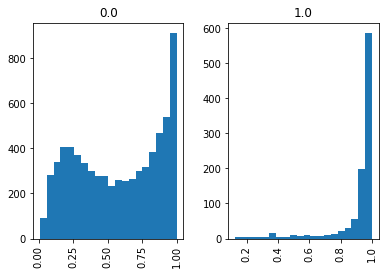

In [20]:
all.loc[all['dispensing_patients']>=1,'dispensing_patients'] =1
all['rate',''].hist(by=all['dispensing_patients'],bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213CE851448>,
      dtype=object)

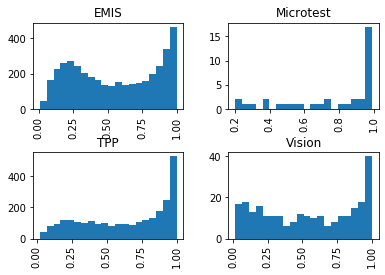

In [21]:
all['rate',''].hist(by=all['supplier'],bins=20)